## Model Selection

Import libraries and load the current modeling data for `AmazonReviews`

In [18]:
from nltk.corpus import words, stopwords
from nltk import SnowballStemmer
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedKFold

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

from skopt import BayesSearchCV

# latest sklearn issue
# class BayesSearchCV(BayesSearchCV):
#     def _run_search(self, x): raise BaseException('Use newer skopt')
        
from skopt.space import Real, Integer, Categorical

from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score


import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

%config InlineBackend.figure_format = 'svg'

stemmer = SnowballStemmer('english')

def english_corpus(doc, tkpat=re.compile('\\b[a-z][a-z]+\\b')):
    return [stemmer.stem(w) for w in tkpat.findall(doc)]

MODELING_PATH = '../data/modeling/'
PATH = '../data/amazon_reviews_us_Toys_v1_00.tsv'

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
from AmazonReviews import AmazonReviews

ar = AmazonReviews()

In [4]:
ar.load_data(PATH)
ar.calc_trend_score()
ar.create_observations()
ar.create_train_test_split()

Read from pickle...


## Setup

Create inital dictionaries of standard parameters to be utilized in the different algorithms. 

In [5]:
skf = StratifiedKFold(n_splits = 5, random_state=ar.RANDOM_STATE)

In [6]:
count_vectorizer_parameters = {
    'stop_words': set(stopwords.words()), 
    'tokenizer': english_corpus, 
    'min_df': 100,
    'max_df': 0.2,
    'ngram_range': (1,2)
}

In [7]:
lda_parameters = {
    'n_components': 5,
    'learning_decay': 0.6,
    'batch_size': 256,
    'learning_offset': 1024,
    'learning_method': 'online',
    'topic_word_prior': 0.005,
    'n_jobs': -1,
    'random_state': ar.RANDOM_STATE
}

xgb_parameters = {
    'random_state': ar.RANDOM_STATE,
    'n_jobs': -1,
    'objective': 'binary:logistic'
}

bayes_cv_parameters = {
    'n_iter': 10,
    'scoring': 'roc_auc',
    'n_jobs': -1,
    'cv': skf,
    'random_state': ar.RANDOM_STATE
}

Create the document transformation pipeline.

In [8]:
doc_pipeline = Pipeline(
    [
        ('cnt_vector', CountVectorizer(**count_vectorizer_parameters)),
        ('lda', LatentDirichletAllocation(**lda_parameters)),
        ('log_tansform', FunctionTransformer(np.log))
    ]
)

Transform `X_train`.

In [18]:
ar.X_train.head()

43652     this is great for your hair  and it chainges c...
110963    Not worth   bucks!!!!! This toy feels really c...
148853    I saw this same size at Walmart for $ . .  Grr...
193505    There is nothing wrong with the quality of the...
141197    I purchased this boat as a RTR boat it ran awe...
Name: review_body, dtype: object

In [9]:
X_train_transformed = doc_pipeline.fit_transform(ar.X_train)
pd.DataFrame(X_train_transformed).head()

,0,1,2,3,4
0,-1.171857,-1.519457,-2.252676,-3.803085,-1.067233
1,-3.386933,-0.663706,-5.518817,-5.505281,-0.813796
2,-3.552461,-0.675773,-3.555348,-0.904099,-3.536834
3,-0.746880,-1.060022,-2.414319,-6.074681,-2.430635
4,-4.932876,-0.375000,-1.234507,-4.922828,-4.926993


In [10]:
# save progress
def save(obj, obj_name):
    f = MODELING_PATH + obj_name
    pickle.dump(obj, open(f, 'wb'))

def load(obj_name):
    f = MODELING_PATH + obj_name
    return pickle.load(open(f, 'rb'))

In [11]:
save(X_train_transformed, 'X_train_transformed.pkl')

Create the parameters to perform `BayesSeachCV` over.

In [7]:
xgb_search_params = {
    'max_depth': Integer(2, 6),
    'learning_rate': Real(0, 0.5),
    'n_estimators': Integer(100, 1000),
    'gamma': Real(0, 0.5)
}

Fit the baseline model.

In [8]:
xgb = XGBClassifier(**xgb_parameters)

In [33]:
bayes_search = BayesSearchCV(xgb, xgb_search_params, **bayes_cv_parameters)
bayes_search.fit(X_train_transformed, ar.y_train)

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_iter=10, n_jobs=-1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=42,
       refit=True, return_train_score=False, scoring='roc_auc',
       search_spaces={'max_depth': Integer(low=2, high=6), 'learning_rate': Real(low=0, high=0.5, prior='uniform', transform='identity'), 'n_estimators': Integer(low=100, high=1000), 'gamma': Real(low=0, high=0.5, prior='uniform', transform='identity')},
       verbose=0)

In [100]:
y_pred = bayes_search.best_estimator_.predict_proba(X_train_transformed)[:,1]

In [68]:
bayes_search.best_params_

{'gamma': 0.4061979941786817,
 'learning_rate': 0.08593578069828035,
 'max_depth': 4,
 'n_estimators': 822}

In [101]:
ar.log_score(ar.y_train, y_pred, 'baseline')
ar.results

,Precision,Recall,F1,Accuracy,AUC
baseline,1.0,0.006575,0.013064,0.989508,0.91225


In [ ]:
save(bayes_search.best_estimator_, 'baeline_estimator.pkl')

In [116]:
save(ar.results, 'results_df.pkl')
save(ar.y_scores, 'y_scores.pkl')

Pretty high AUC, but the confusion matrix metrics are most likely skewed with the default cutoff of 50%.

## Next model

Let's now try up-sampling to see if this can improve the classification.

In [38]:
sm = SMOTE(random_state=ar.RANDOM_STATE, n_jobs=-1)

In [105]:
X_train_SMOTE, y_train_SMOTE = sm.fit_sample(X_train_transformed, ar.y_train)

save(X_train_SMOTE, 'X_train_baseline_SMOTE.pkl')
save(y_train_SMOTE, 'y_train_baseline_SMOTE.pkl')

In [11]:
# add some logging in the BayesSearchCV
bayes_cv_parameters['verbose'] = 2
bayes_cv_parameters['n_jobs'] = -1

In [10]:
X_train_SMOTE = load('X_train_baseline_SMOTE.pkl')
y_train_SMOTE = load('y_train_baseline_SMOTE.pkl')

In [14]:
bayes_search = BayesSearchCV(xgb, xgb_search_params, **bayes_cv_parameters)
bayes_search.fit(X_train_SMOTE, y_train_SMOTE)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   50.6s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   53.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   53.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.8min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   38.0s remaining:   57.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.8min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_iter=10, n_jobs=-1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=42,
       refit=True, return_train_score=False, scoring='roc_auc',
       search_spaces={'max_depth': Integer(low=2, high=6), 'learning_rate': Real(low=0, high=0.5, prior='uniform', transform='identity'), 'n_estimators': Integer(low=100, high=1000), 'gamma': Real(low=0, high=0.5, prior='uniform', transform='identity')},
       verbose=2)

In [33]:
ar.results = load('results_df.pkl')
ar.y_scores = load('y_scores.pkl')
# ar.X_train = load('X_train.pkl')
# ar.y_train = load('y_train.pkl')
bayes_search = load('base_SMOTE_search.pkl')
# X_train_transformed = load('X_train_transformed.pkl')

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.20.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [13]:
y_pred = bayes_search.best_estimator_.predict_proba(X_train_transformed)[:,1]

In [14]:
ar.log_score(ar.y_train, y_pred, 'base_SMOTE')
ar.results

,Precision,Recall,F1,Accuracy,AUC
baseline,1.000000,0.006575,0.013064,0.989508,0.912250
base_SMOTE,0.090632,0.889420,0.164502,0.904577,0.954279


In [17]:
save(bayes_search, 'base_SMOTE_search.pkl')

In [30]:
save(ar.results, 'results_df.pkl')
save(ar.y_scores, 'y_scores.pkl')
save(set(stopwords.words()), 'stop_words.pkl')

Applying SMOTE increased the AUC from **0.91** to **0.95**.

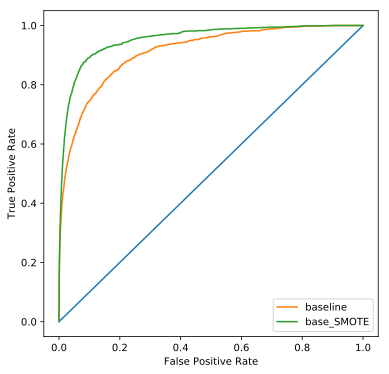

In [35]:
ar.y_train = load('y_train.pkl')
ar.plot_roc_curve();

In [37]:
pd.DataFrame(bayes_search.cv_results_)

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,params
0,0.960582,0.962195,0.963695,0.962545,0.963071,0.962417,0.001048,1,131.605353,6.409632,2.174358,0.075748,0.205052,0.363863,6,384,"{'gamma': 0.20505197942665693, 'learning_rate'..."
1,0.925359,0.927932,0.928073,0.925255,0.926735,0.926671,0.001207,1,144.832665,4.419363,2.492490,0.075087,0.418694,0.441658,3,956,"{'gamma': 0.4186941777766422, 'learning_rate':..."
2,0.866802,0.868914,0.871680,0.867752,0.869805,0.868991,0.001687,1,50.587465,1.348302,0.804338,0.019146,0.222416,0.459361,2,490,"{'gamma': 0.22241625615057592, 'learning_rate'..."
3,0.899488,0.900598,0.902920,0.899384,0.901746,0.900827,0.001353,1,167.442361,7.007807,3.091239,0.326487,0.406198,0.085936,4,822,"{'gamma': 0.4061979941786817, 'learning_rate':..."
4,0.929790,0.930470,0.932193,0.930184,0.929915,0.930510,0.000873,1,151.537634,5.898930,2.728583,0.296684,0.399777,0.219015,4,744,"{'gamma': 0.39977672080358656, 'learning_rate'..."
5,0.887197,0.890073,0.890302,0.888800,0.889586,0.889192,0.001122,1,39.956739,2.889590,0.593178,0.013056,0.367014,0.469685,3,270,"{'gamma': 0.3670140089927842, 'learning_rate':..."
6,0.920605,0.920990,0.923419,0.920443,0.922031,0.921498,0.001108,1,133.593584,5.604732,2.595621,0.414627,0.308540,0.387682,3,887,"{'gamma': 0.30853967925115816, 'learning_rate'..."
7,0.948185,0.949971,0.951296,0.949195,0.950708,0.949871,0.001099,1,173.675009,9.012285,2.858368,0.052708,0.271702,0.460005,4,854,"{'gamma': 0.2717015338451563, 'learning_rate':..."
8,0.949778,0.951459,0.953071,0.951310,0.951522,0.951428,0.001044,1,123.396385,6.642083,2.298788,0.095749,0.477739,0.350311,5,474,"{'gamma': 0.47773899315496415, 'learning_rate'..."
9,0.945511,0.945655,0.947522,0.946246,0.946391,0.946265,0.000712,1,86.641596,5.912686,1.520371,0.086364,0.001815,0.408915,5,329,"{'gamma': 0.0018151536273716133, 'learning_rat..."


## Next Model

Let's now see the impact of increasing the LDA topics from 5 to 10 and applying SMOTE.

In [ ]:
lda_parameters['n_components'] = 10
count_vectorizer_parameters['stop_words'] = load('stop_words.pkl')

doc_pipeline = Pipeline(
    [
        ('cnt_vector', CountVectorizer(**count_vectorizer_parameters)),
        ('lda', LatentDirichletAllocation(**lda_parameters)),
        ('log_tansform', FunctionTransformer(np.log))
    ]
)

X_train_transformed = doc_pipeline.fit_transform(ar.X_train)
save(X_train_transformed, 'X_train_transformed_10_topics.pkl')

X_train_SMOTE, y_train_SMOTE = sm.fit_sample(X_train_transformed, ar.y_train)
save(X_train_SMOTE, 'X_train_SMOTE_10t.pkl')
save(y_train_SMOTE, 'y_train_SMOTE_10t.pkl')

In [ ]:
bayes_search.fit(X_train_SMOTE, y_train_SMOTE)
save(bayes_search, 'SMOTE_10t_search.pkl')